In [1]:
import numpy as np
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

In [2]:
#Actions: hit and stick
actionHit = 0
actionStick = 1
actions = [actionHit, actionStick]

In [3]:
#policy for the player
policyPlayer = np.zeros(22)
for i in range(12, 20):
    policyPlayer[i] = actionHit
policyPlayer[20] = actionStick
policyPlayer[21] = actionStick

In [4]:
#function form of target policy of the player
def targetPolicyPlayer(usableAcePlayer, playerSum, dealerCard):
    return policyPlayer[playerSum]

In [5]:
#function form of behaviour policy of the player
def behaviourPolicyPlayer(usableAcePlayer, playerSum, dealerCard):
    if np.random.binomial(1, 0.5) == actionStick:
        return actionStick
    return actionHit

In [6]:
#policy for dealer
policyDealer = np.zeros(22)
for i in range(12, 17):
    policyDealer[i] = actionHit
for i in range(17, 22):
    policyDealer[i] = actionStick

In [7]:
#function to get new card
def getCard():
    card = np.random.randint(1, 14)
    card = min(card, 10) #face cards have value equal to 10
    return card

#function to get value of a card
def cardValue(cardid):
    return 11 if cardid == 1 else cardid

In [8]:
def play(policyPlayer, initialState = None, initialAction = None):
    #player Status 
    #Sum of player cards
    playerSum = 0
    
    #Trajectory of player
    playerTrajectory = []
    
    #Usable ace or not
    useableAcePlayer = False
    
    #Dealer Status
    dealerCard1 = 0
    dealerCard2 = 0
    useableAceDealer = False
    
    if initialState is None:
        #Generate random initial State
        
        while playerSum < 12:
            card = getCard()
            playerSum += cardValue(card)
            
            if playerSum > 21:
                assert playerSum == 22 #Last card must be ace
                playerSum -= 10
            else:
                useableAcePlayer |= (1 == card)
        
        dealerCard1 = getCard()
        dealerCard2 = getCard()
        
    else:
        #Use specified initial state
        useableAcePlayer, playerSum, dealerCard1 = initialState
        dealerCard2 = getCard()
        
    state = [useableAcePlayer, playerSum, dealerCard1]
    
    dealerSum = cardValue(dealerCard1) + cardValue(dealerCard2)
    useableAceDealer = 1 in (dealerCard1, dealerCard2)
    
    #if the sum is greater than 21, dealer must hold 2 aces
    if dealerSum > 21:
        assert dealerSum == 22
        dealerSum -= 10 # Use one ace 1 rather than 11
    assert dealerSum <= 21
    assert playerSum <= 21
    
    #Game starts
    
    #Player's Turn
    while True:
        if initialAction is not None:
            action = initialAction
            initialAction = None
        else:
            #get action based on current turn
            action = policyPlayer(useableAcePlayer, playerSum, dealerCard1)
            
        #track player's tracjectory for importance sampling 
        playerTrajectory.append([(useableAcePlayer, playerSum, dealerCard1), action])
        
        if action == actionStick:
            break
        #if hit, get a new card
        card = getCard()
        
        #Keep track of the ace count, as the useableAcePlayer alone is insufficient to track the ace count
        
        aceCount = int(useableAcePlayer)
        if card == 1:
            aceCount += 1
        playerSum += cardValue(card)
        
        #If the player has a usable ace, use it as a 1 to avoid going bust
        while playerSum > 21 and aceCount:
            playerSum -= 10
            aceCount -= 1
            
        #if player goes bust
        if playerSum > 21:
            return state, -1, playerTrajectory
        assert playerSum <= 21
        useableAcePlayer = (aceCount == 1)
    
    #Dealer's Turn
    while True:
        #get action based on current sum
        action = policyDealer[dealerSum]
        if action == actionStick:
            break
            
        #if hit, get a new card
        newCard = getCard()
        aceCount = int(useableAceDealer)
        #Same as player, calculate ace count as usableAceDealer alone is not sufficient
        if newCard == 1:
            aceCount += 1
        
        dealerSum += cardValue(newCard)
        
        # If the dealer has a usable ace, use it as 1 to avoid going bust
        while dealerSum > 21 and aceCount:
            dealerSum -= 10
            aceCount -= 1
            
        #If dealer goes bust
        if dealerSum > 21:
            return state, 1, playerTrajectory
        
        useableAceDealer = (aceCount == 1)
        
    #Compare player and dealer
    assert playerSum <= 21 and dealerSum <= 21
    if playerSum > dealerSum:
        return state, 1, playerTrajectory
    elif playerSum == dealerSum:
        return state, 0, playerTrajectory
    else:
        return state, -1, playerTrajectory

In [9]:
#On policy Monte Carlo
def monteCarloOnPolicy(episodes):
    statesUseableAce = np.zeros((10, 10))
    # initialze counts to 1 to avoid divide by zero error
    statesUseableAceCount = np.ones((10, 10))
    
    statesNoUseableAce = np.zeros((10, 10))
    # initialze counts to 1 to avoid divide by zero error
    statesNoUseableAceCount = np.ones((10, 10))
    
    for i in tqdm(range(0, episodes)):
        _, reward, playerTracjectory = play(targetPolicyPlayer)
        
        for (useableAce, playerSum, dealerCard), _ in playerTracjectory:
            playerSum -= 12
            dealerCard -= 1
            
            if useableAce:
                statesUseableAceCount[playerSum, dealerCard] += 1
                statesUseableAce[playerSum, dealerCard] += reward
            
            else:
                statesNoUseableAceCount[playerSum, dealerCard] += 1
                statesNoUseableAce[playerSum, dealerCard] += reward
                
    
    return statesUseableAce / statesUseableAceCount, statesNoUseableAce / statesNoUseableAceCount

100%|██████████| 500000/500000 [00:14<00:00, 33761.69it/s]


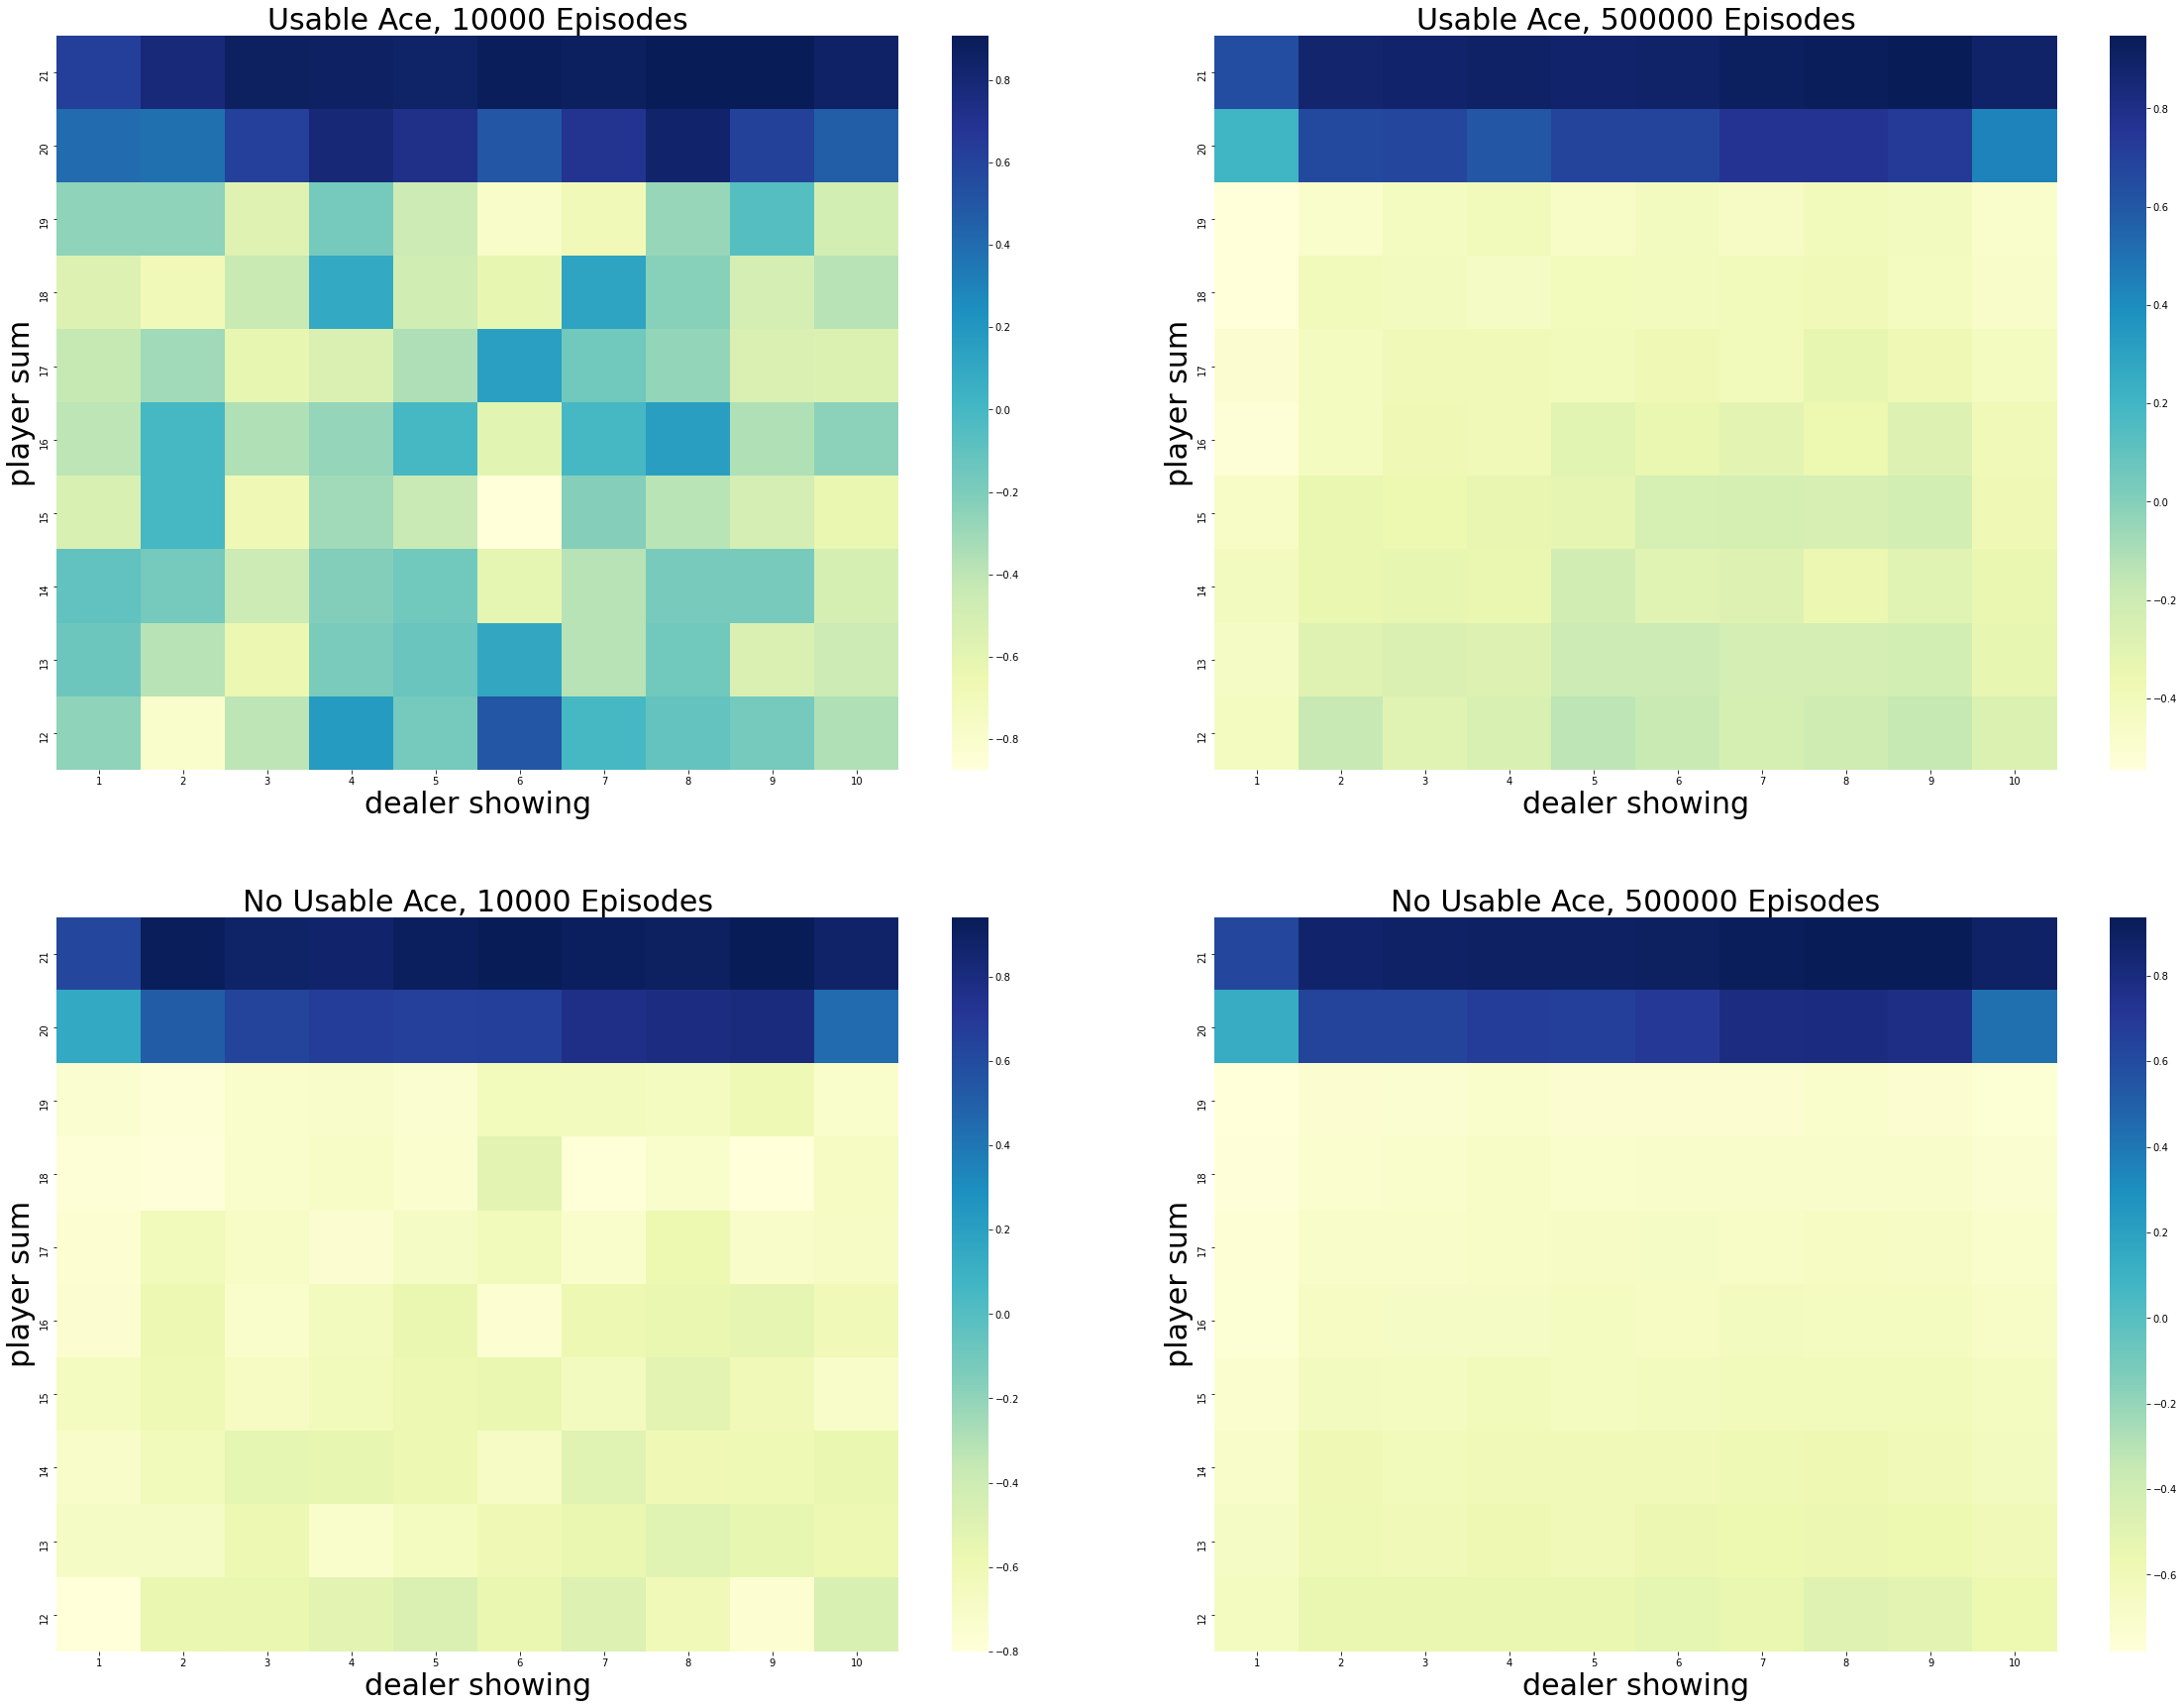

In [10]:
statesUseableAce1, statesNoUseableAce1 = monteCarloOnPolicy(10000)
statesUseableAce2, statesNoUseableAce2 = monteCarloOnPolicy(500000)

states = [statesUseableAce1, statesUseableAce2, statesNoUseableAce1, statesNoUseableAce2]  
titles = ['Usable Ace, 10000 Episodes', 'Usable Ace, 500000 Episodes',
          'No Usable Ace, 10000 Episodes', 'No Usable Ace, 500000 Episodes']

_, axes = plt.subplots(2, 2, figsize=(40, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

for state, title, axis in zip(states, titles, axes):
    fig = sns.heatmap(np.flipud(state), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
    fig.set_ylabel('player sum', fontsize=30)
    fig.set_xlabel('dealer showing', fontsize=30)
    fig.set_title(title, fontsize=30)
    
plt.show()

In [14]:
# Monte Carlo with Exploring Starts
def monteCarloES(episodes):
    # (playerSum, dealerCard, usableAce, action)
    stateActionValues = np.zeros((10, 10, 2, 2))
    # initialze counts to 1 to avoid division by 0
    stateActionPairCount = np.ones((10, 10, 2, 2))

    # behavior policy is greedy
    def behaviorPolicy(usableAce, playerSum, dealerCard):
        usableAce = int(usableAce)
        playerSum -= 12
        dealerCard -= 1
        # get argmax of the average returns(s, a)
        values_ = stateActionValues[playerSum, dealerCard, usableAce, :] / \
                  stateActionPairCount[playerSum, dealerCard, usableAce, :]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])

    # play for several episodes
    for episode in tqdm(range(episodes)):
        # for each episode, use a randomly initialized state and action
        initialState = [bool(np.random.choice([0, 1])),
                       np.random.choice(range(12, 22)),
                       np.random.choice(range(1, 11))]
        initialAction = np.random.choice(actions)
        currentPolicy = behaviorPolicy if episode else targetPolicyPlayer
        _, reward, trajectory = play(currentPolicy, initialState, initialAction)
        firstVisitCheck = set()
        for (usableAce, playerSum, dealerCard), action in trajectory:
            usableAce = int(usableAce)
            playerSum -= 12
            dealerCard -= 1
            stateAction = (usableAce, playerSum, dealerCard, action)
            if stateAction in firstVisitCheck:
                continue
            firstVisitCheck.add(stateAction)
            # update values of state-action pairs
            stateActionValues[playerSum, dealerCard, usableAce, action] += reward
            stateActionPairCount[playerSum, dealerCard, usableAce, action] += 1

    return stateActionValues / stateActionPairCount

100%|██████████| 500000/500000 [00:31<00:00, 15849.60it/s]


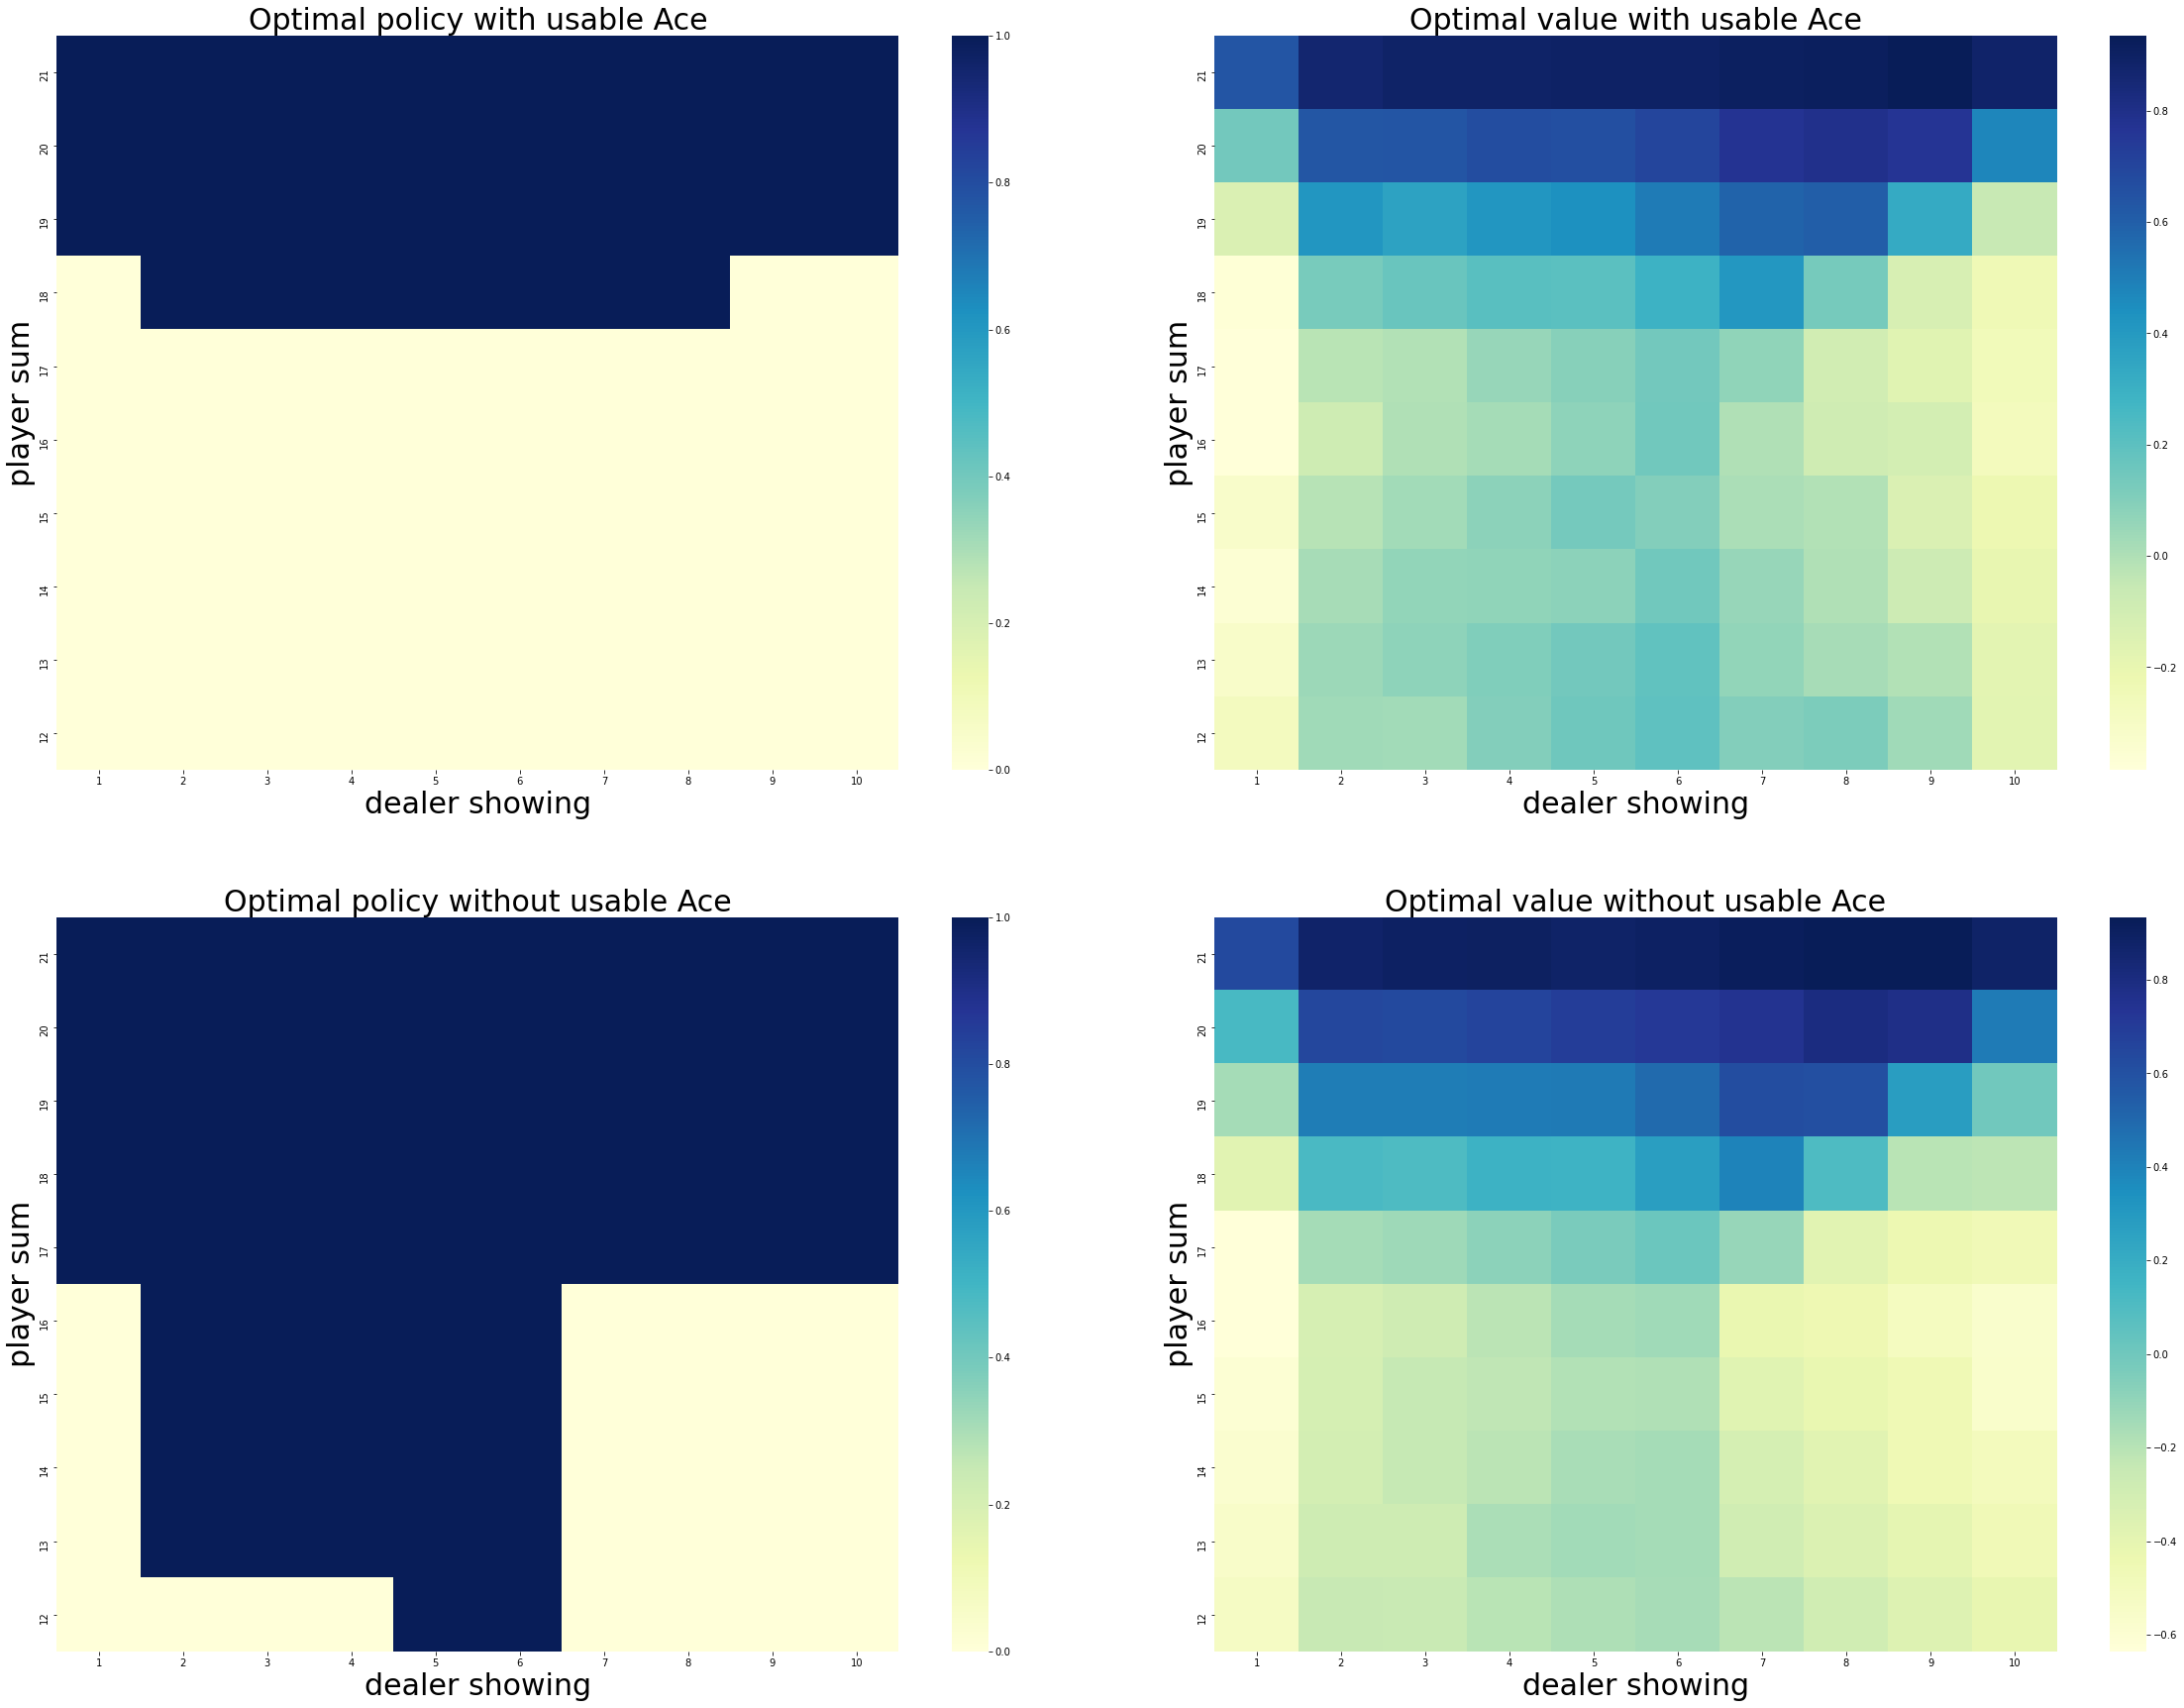

In [19]:
stateActionValues = monteCarloES(500000)

stateValueNoUsableAce = np.max(stateActionValues[:, :, 0, :], axis=-1)
stateValueUsableAce = np.max(stateActionValues[:, :, 1, :], axis=-1)

#get the optimmal policy 
actionNoUsableAce = np.argmax(stateActionValues[:, :, 0, :], axis=-1)
actionUsableAce = np.argmax(stateActionValues[:, :, 1, :], axis=-1)

images = [actionUsableAce,
              stateValueUsableAce,
              actionNoUsableAce,
              stateValueNoUsableAce]
titles = ['Optimal policy with usable Ace', 'Optimal value with usable Ace',
          'Optimal policy without usable Ace', 'Optimal value without usable Ace']

_, axes = plt.subplots(2, 2, figsize=(40, 30))
plt.subplots_adjust(wspace=0.1, hspace=0.2)
axes = axes.flatten()

for image, title, axis in zip(images, titles, axes):
    fig = sns.heatmap(np.flipud(image), cmap="YlGnBu", ax=axis, xticklabels=range(1, 11),
                          yticklabels=list(reversed(range(12, 22))))
    fig.set_ylabel('player sum', fontsize = 30)
    fig.set_xlabel('dealer showing', fontsize = 30)
    fig.set_title(title, fontsize = 30)